In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats 
df = pd.read_excel('/Users/mariaovchinnikova/Андан Проект/DataFrame_Spotify.xlsx', engine='openpyxl')

## Тепловая карта корреляции всех фичей датасета

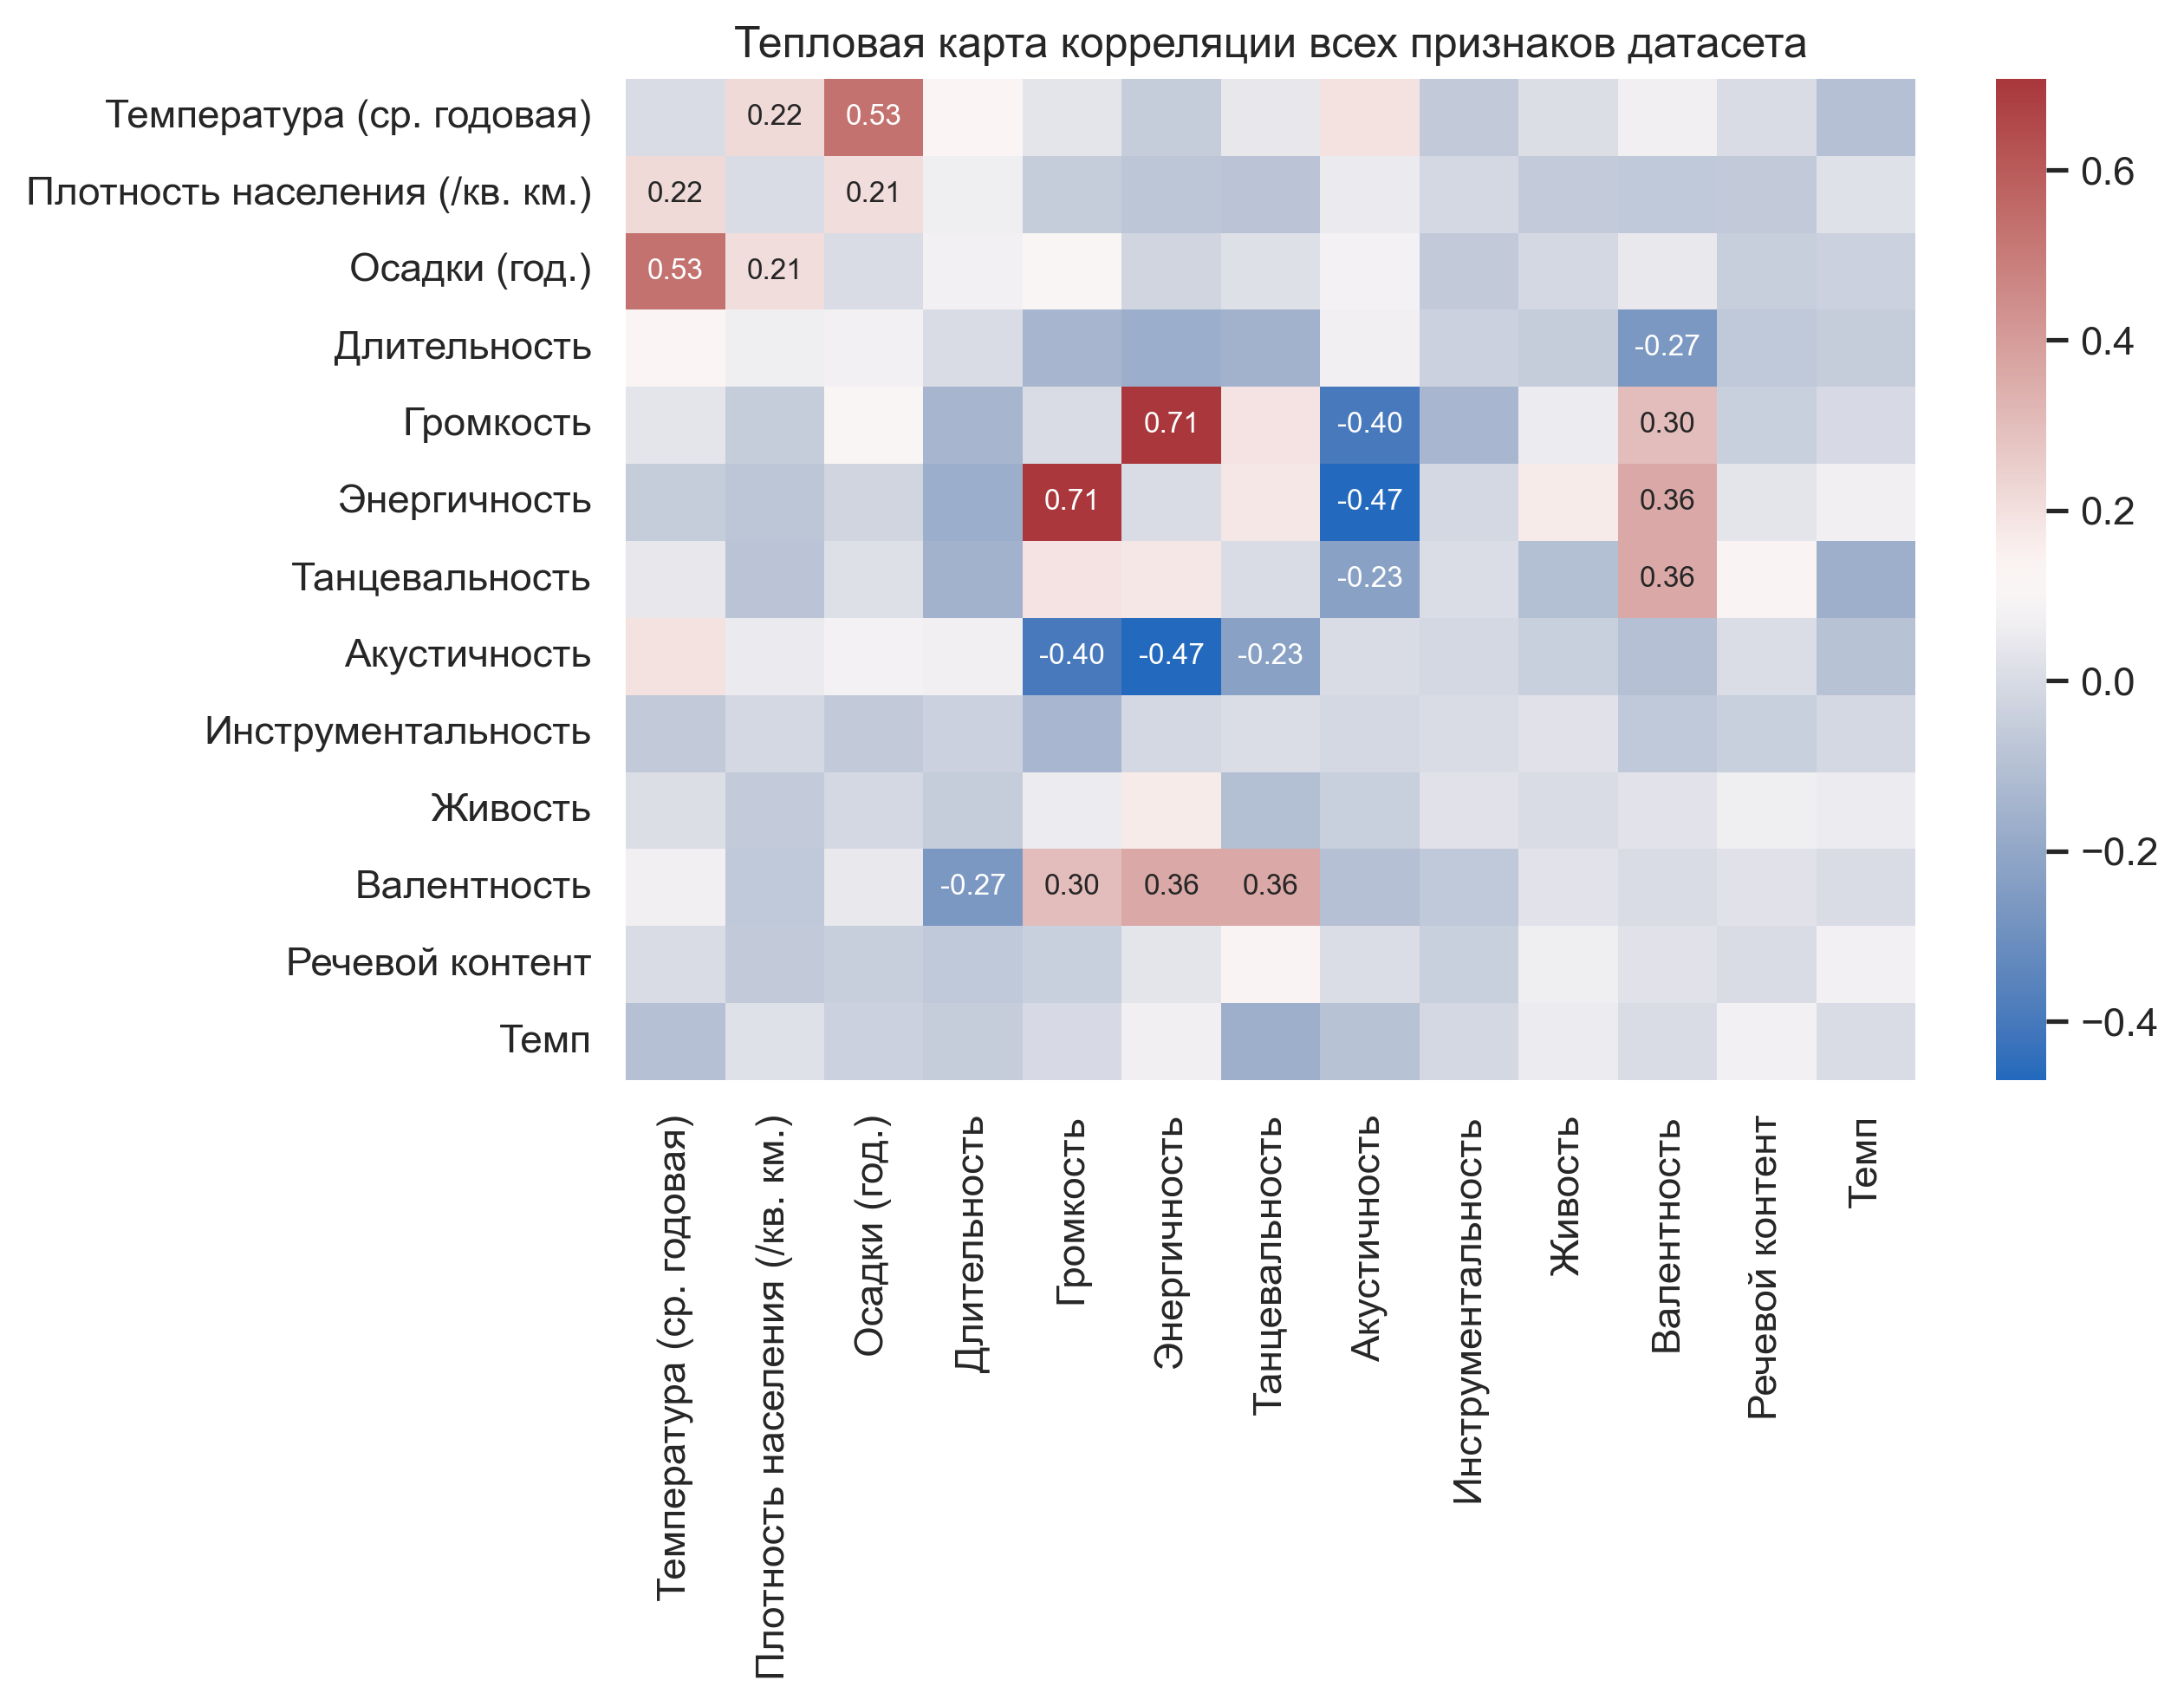

In [22]:
correlation = df.corr(numeric_only=True)
corr_graph = correlation - np.eye(correlation.shape[0])

plt.figure(figsize=(8, 5), dpi=300)

plt.title('Тепловая карта корреляции всех признаков датасета')

ax = sns.heatmap(corr_graph,
                 cmap='vlag',
                 annot=True,
                 fmt='0.2f',
                 annot_kws={'size': 8})

for t in ax.texts:
    if float(t.get_text()) >= 0.2 or float(t.get_text()) <= -0.2:
        t.set_text(t.get_text())
    else:
        t.set_text("")

### Гипотеза 1: Чем ближе страна находится к экваториальному тропическому поясу, тем песня более веселая и энергичная (мы взяли для анализа к-т оптимизма)
Первая гипотеза самая сложная для анализа. Для нее требуется составление отдельного параметра, такого как **коэффициент оптимизма**. Он определяется как сумма показателей темп, энергичность, танцевальность, валентность. Так же в ДФ нужно добавить, в каком климатическом поясе находится страна - сделали это в таблице эксель

Здесь наметим план: составить новую табличку df_h1, где будут 3 столбца: первый столбец со странами, второй столбец мо значением к-та оптимизма, 3 столбец с климатическим поясом. Далее в планах сгруппировать страны по климатическим поясам, построить графики для каждого климат пояса (гистограмма от 1 переменной), объединить их и далее будет видно, была ли гипотеза правдива или же нет.

In [23]:
from sklearn.preprocessing import MinMaxScaler

#перекодируем переменную относительно 0 и 1 
df_draft = pd.DataFrame(df['Темп'])

scaler = MinMaxScaler()
df_draft['Темп_2'] = scaler.fit_transform(df_draft[['Темп']])
df_draft.head()

,Темп,Темп_2
0,130.104,0.477547
1,92.010,0.240454
2,168.004,0.713433
3,98.325,0.279758
4,100.019,0.290301


In [24]:
df['Темп Coded'] = df_draft['Темп_2']
df['Positivity'] = df['Темп Coded'] + df['Энергичность'] + df['Танцевальность'] + df['Валентность']

In [25]:
df_for_table = df[['Страны', 'Positivity', 'Климатический пояс']] #собираем нужные столбцы

df_h1 = pd.DataFrame(df_for_table.groupby(['Страны', 'Климатический пояс'])['Positivity'].mean())
df_h1.head()

,,Positivity
Страны,Климатический пояс,
Argentina,Умеренный,2.454331
Australia,Тропический,2.162425
Austria,Умеренный,2.385449
Belarus,Умеренный,2.295110
Belgium,Умеренный,2.393178


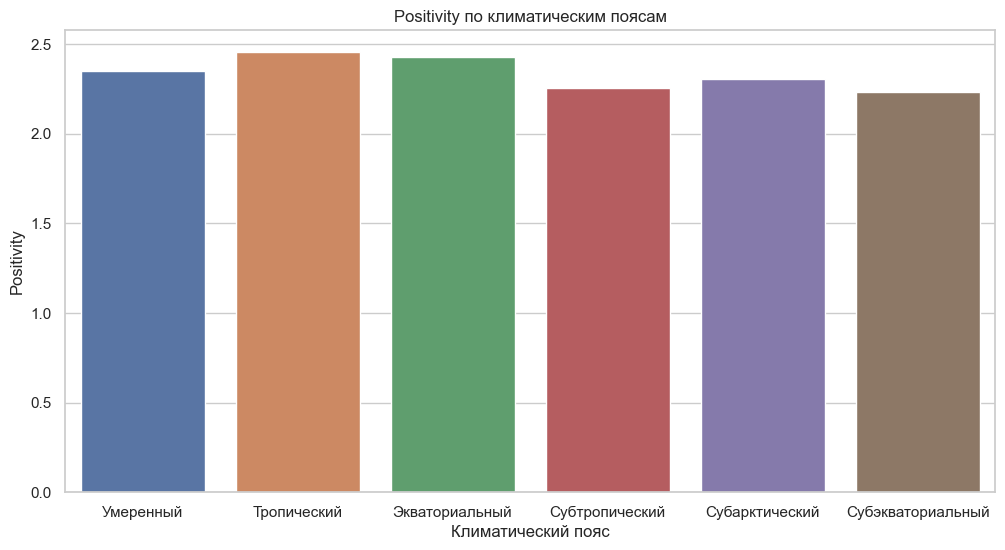

In [26]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_h1.reset_index(), x='Климатический пояс', y='Positivity', errorbar=None)

plt.title('Positivity по климатическим поясам')
plt.xlabel('Климатический пояс')
plt.ylabel('Positivity')

plt.show()

### Вывод по гипотезе 1: 

Действительно, исходя из получившейся гистограммы, можно заметить, что коэффициент позитивности песен немного растет при приближении к экватору. Наша гипотеза подтвердилась.

### Гипотеза 2: чем ниже в стране температура, тем более спокойную(тихую) музыку люди предпочитают слушать(параметр громкость, живость и длительность)
По сути, это удаленность от экватора, хоть и с некоторыми поправками. 

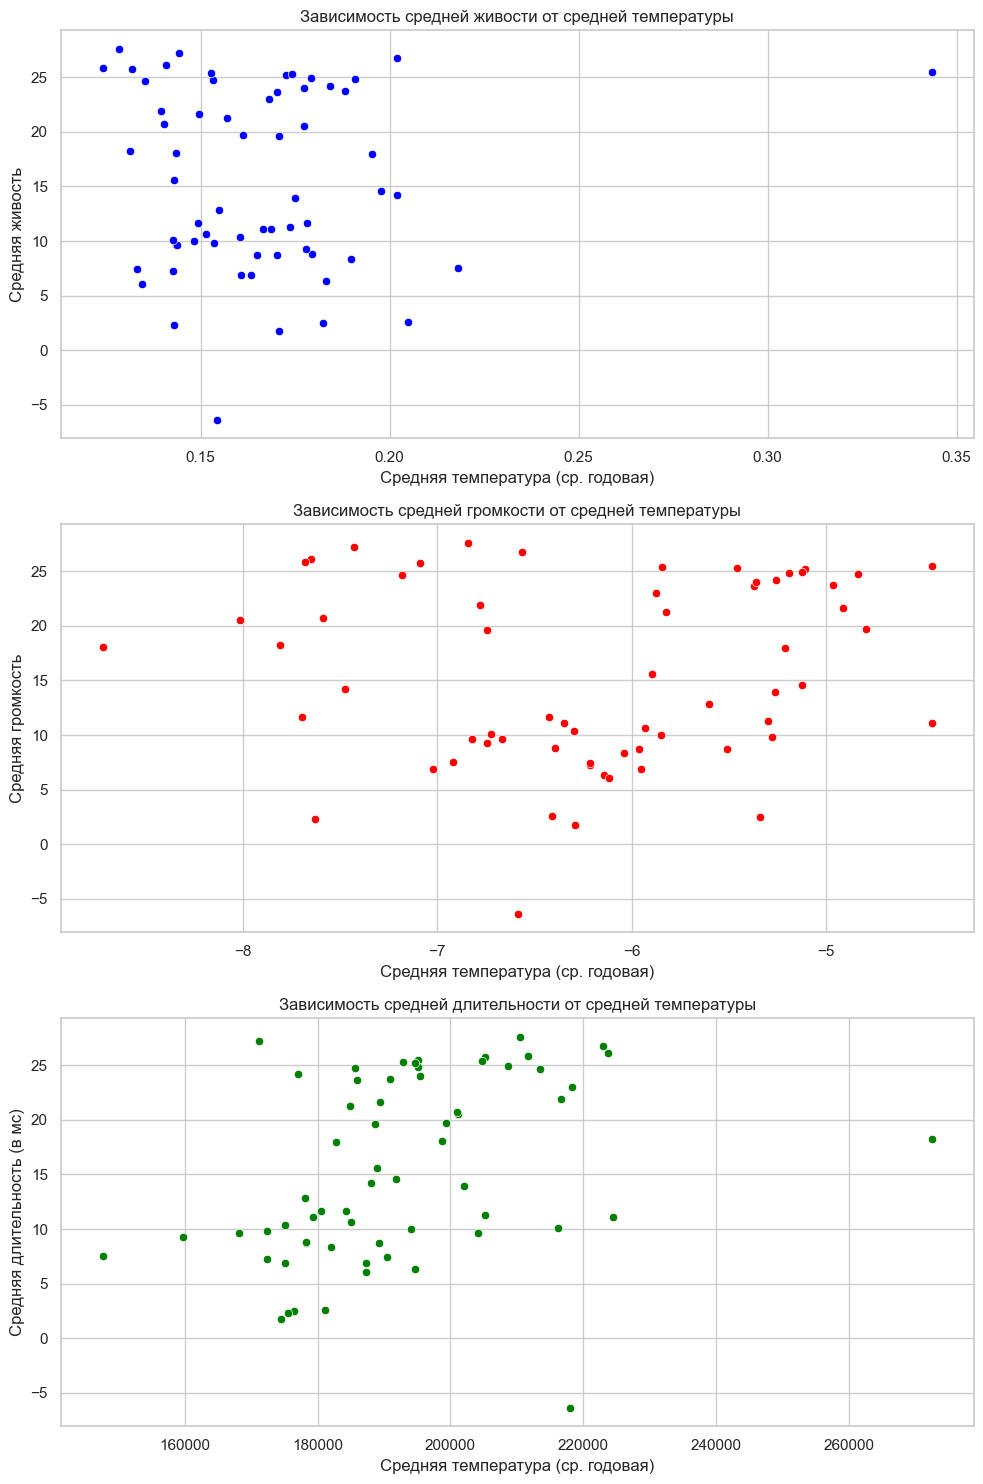

In [27]:
grouped_data = df.groupby('Страны').agg(
    Средняя_живость=pd.NamedAgg(column='Живость', aggfunc='mean'),
    Средняя_громкость=pd.NamedAgg(column='Громкость', aggfunc='mean'),
    Средняя_длительность=pd.NamedAgg(column='Длительность', aggfunc='mean'),
    Средняя_температура=pd.NamedAgg(column='Температура (ср. годовая)', aggfunc='mean') 
)
grouped_data.reset_index(inplace=True)

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

sns.scatterplot(data=grouped_data, x='Средняя_живость', y='Средняя_температура', ax=axs[0], color='blue')
axs[0].set_title('Зависимость средней живости от средней температуры')
axs[0].set_ylabel('Средняя живость')
axs[0].set_xlabel('Средняя температура (ср. годовая)')

sns.scatterplot(data=grouped_data, x='Средняя_громкость', y='Средняя_температура', ax=axs[1], color='red')
axs[1].set_title('Зависимость средней громкости от средней температуры')
axs[1].set_ylabel('Средняя громкость')
axs[1].set_xlabel('Средняя температура (ср. годовая)')

sns.scatterplot(data=grouped_data, x='Средняя_длительность', y='Средняя_температура', ax=axs[2], color='green')
axs[2].set_title('Зависимость средней длительности от средней температуры')
axs[2].set_ylabel('Средняя длительность (в мс)')
axs[2].set_xlabel('Средняя температура (ср. годовая)')

plt.tight_layout()

### Вывод по гипотезе 2: 

Из данных мы можем сделать вывод, что в случае с длительностью:
в холодных странах (температура ниже 5 градусов) треки достаточно короткие
в странах со средней температурой от 5 до 13 градусов достаточно большой разброс значений, оценить что либо сложно
и в жарких странах треки в среднем длиннее, чем в холодных, видимо, люди любят повеселиться :)

В случае средней громкости если построить тренд(в будущем сделаем), то увидим, что в среднем чем больше температура, тем больше длительность трека.

Анализ средней живости же не дал практически никаких результатов. По данным в среднем живость примерно одинакова как в хл+олодных, так и в горячих странах. 

Отсюда делаем вывод, что изначальная гипотеза частично верна. Действительно, громкость выше в жарких странах, как и длительность. А вот по живости не все так ясно :(

### Гипотеза 3: В топ-5 плейлиста каждой страны в среднем в песнях больше слов и лирики

Для проверки необходимо сравнить: речевой контент и инструментальность, проверим на уровне 95%

In [28]:
from scipy.stats import ttest_rel

top_5_playlists = df.groupby('Страны').head(5)

mean_values = top_5_playlists.groupby('Страны')[['Речевой контент', 'Инструментальность']].mean()

t_statistic, p_value = ttest_rel(mean_values['Речевой контент'], mean_values['Инструментальность'])

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

alpha = 0.05
if p_value < alpha:
    print('True')
else:
    print('False')

T-Statistic: 12.018030862341
P-Value: 1.10661204326212e-18
True


### Вывод по гипотезе 3: 

Разница статистически значима: в топ-5 плейлистов каждой страны песни в среднем содержат больше слов и лирики, чем инструментальности, содержат больше разговорного текста. 

### Гипотеза 4: Чем больше в стране плотность населения, тем выше в ней все параметры для песен кроме длительности

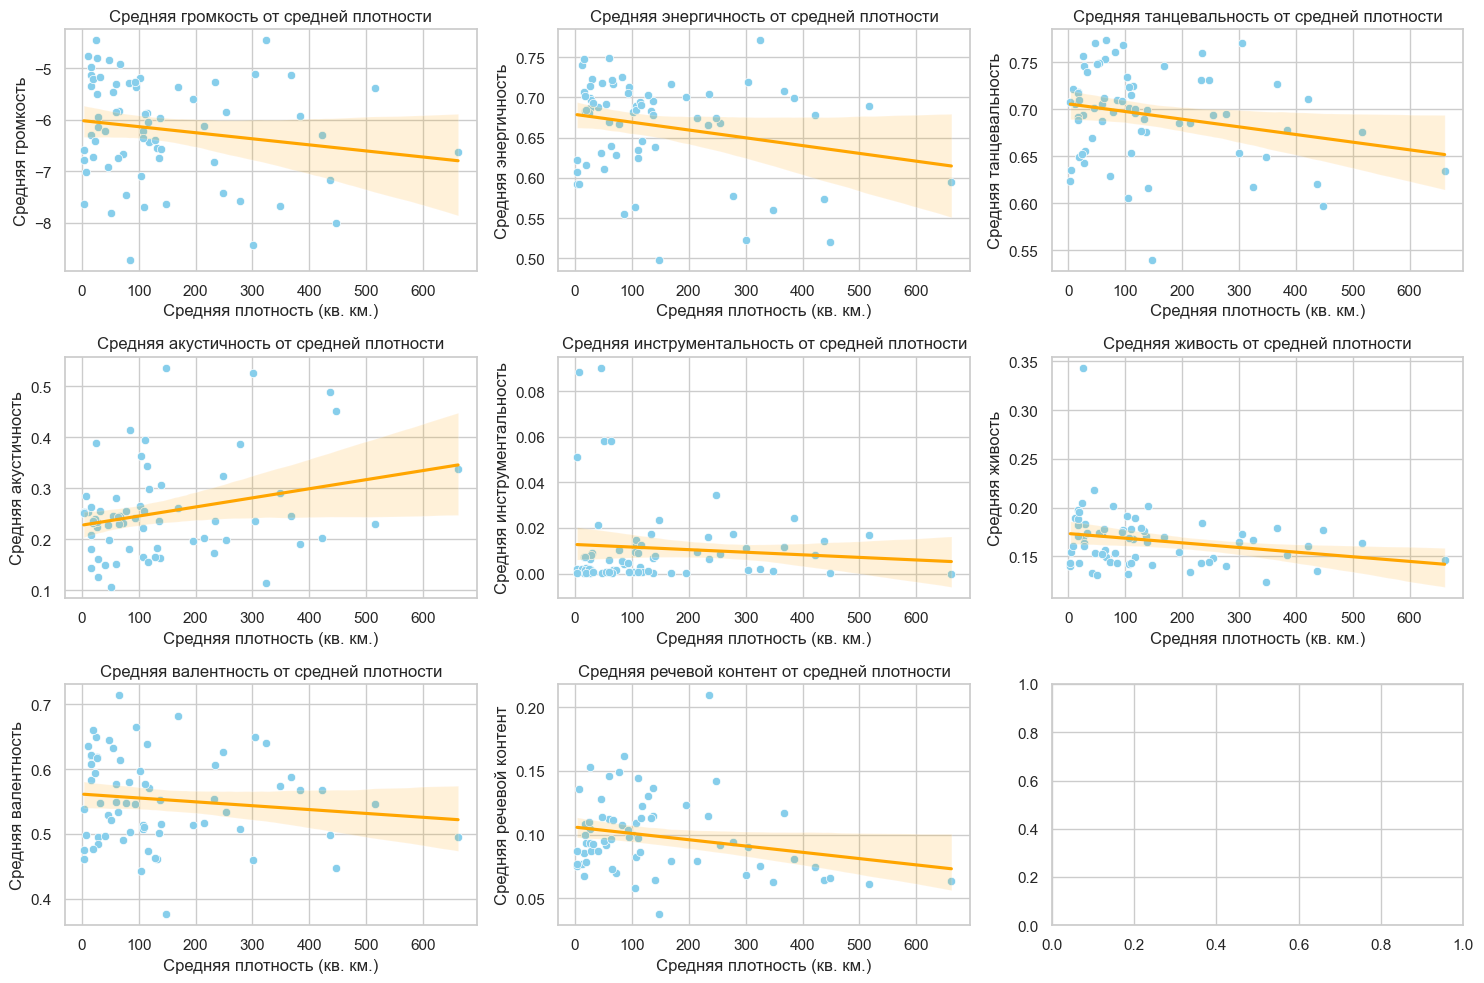

In [29]:
grouped_data = df.groupby('Страны').agg(
    Средняя_плотность=pd.NamedAgg(column='Плотность населения (/кв. км.)', aggfunc='mean'),
    Средняя_громкость=pd.NamedAgg(column='Громкость', aggfunc='mean'),
    Средняя_энергичность=pd.NamedAgg(column='Энергичность', aggfunc='mean'),
    Средняя_танцевальность=pd.NamedAgg(column='Танцевальность', aggfunc='mean'),
    Средняя_акустичность=pd.NamedAgg(column='Акустичность', aggfunc='mean'),
    Средняя_инструментальность=pd.NamedAgg(column='Инструментальность', aggfunc='mean'),
    Средняя_живость=pd.NamedAgg(column='Живость', aggfunc='mean'),
    Средняя_валентность=pd.NamedAgg(column='Валентность', aggfunc='mean'),
    Средняя_речевой_контент=pd.NamedAgg(column='Речевой контент', aggfunc='mean')
)


sns.set(style="whitegrid")

# Фильтрация данных для исключения выбросов
filtered_data = grouped_data[(grouped_data['Средняя_плотность'] > 0) & (grouped_data['Средняя_плотность'] <= 2000)]

fig, axs = plt.subplots(3, 3, figsize=(15, 10))
features = ['Средняя_громкость', 'Средняя_энергичность', 'Средняя_танцевальность', 'Средняя_акустичность', 
            'Средняя_инструментальность', 'Средняя_живость', 'Средняя_валентность', 'Средняя_речевой_контент']

for i, feature in enumerate(features):
    if i < 8:
        ax = axs[i // 3, i % 3]
        sns.scatterplot(data=filtered_data, x='Средняя_плотность', y=feature, ax=ax, color='skyblue')
        sns.regplot(data=filtered_data, x='Средняя_плотность', y=feature, ax=ax, scatter=False, color='orange')
        ax.set_title(f'{feature.replace("_", " ")} от средней плотности')
        ax.set_xlabel('Средняя плотность (кв. км.)')
        ax.set_ylabel(feature.replace("_", " "))
    else:
        plt.delaxes(axs.flatten()[i])

plt.tight_layout()
plt.show()

### Вывод по гипотезе 4: 

Видим, что практически на всех графиках получается так, что при увеличении средней плотности населения наша гипотеза не всегда соблюдается. Это видно на примере энергичности, на примере средней валентности, среднего речевого контента и т.д. Скорее наблюдается обратная зависимость, но она будет доказана позже.

### Гипотеза 5: Чем в стране больше дождей (кол-во осадков), тем больше минорных треков в топ-50 плейлисте.

Корреляция между количеством осадков и долей минорных треков: -0.2543557863219581
                             OLS Regression Results                             
Dep. Variable:     Доля_минорных_треков   R-squared:                       0.065
Model:                              OLS   Adj. R-squared:                  0.050
Method:                   Least Squares   F-statistic:                     4.427
Date:                  Sun, 02 Jun 2024   Prob (F-statistic):             0.0393
Time:                          23:50:27   Log-Likelihood:                 31.899
No. Observations:                    66   AIC:                            -59.80
Df Residuals:                        64   BIC:                            -55.42
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

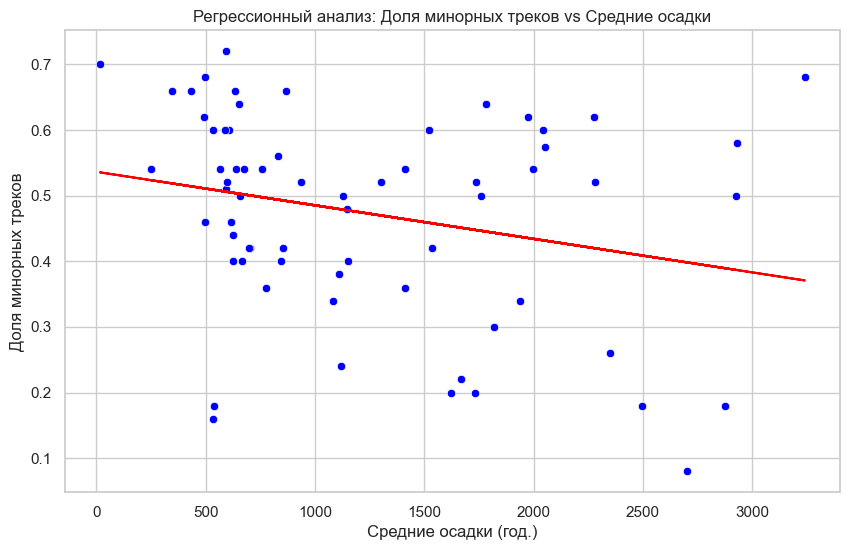

NameError: name 'stats' is not defined

In [30]:
import statsmodels.api as sm

df['is_minor'] = df['Мажорность/минорность'] == 'Minor'

grouped_data = df.groupby('Страны').agg(
    Средние_осадки=pd.NamedAgg(column='Осадки (год.)', aggfunc='mean'),
    Доля_минорных_треков=pd.NamedAgg(column='is_minor', aggfunc='mean')
)

grouped_data = grouped_data.dropna()

correlation = grouped_data['Средние_осадки'].corr(grouped_data['Доля_минорных_треков'])
print(f"Корреляция между количеством осадков и долей минорных треков: {correlation}")

# Линейная регрессионная модель
X = grouped_data['Средние_осадки']
y = grouped_data['Доля_минорных_треков']
X = sm.add_constant(X)  # Добавление константы

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

print(model.summary())

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Средние_осадки', y='Доля_минорных_треков', data=grouped_data, color='blue')
plt.plot(grouped_data['Средние_осадки'], predictions, color='red')
plt.xlabel('Средние осадки (год.)')
plt.ylabel('Доля минорных треков')
plt.title('Регрессионный анализ: Доля минорных треков vs Средние осадки')
plt.show()

grouped_data['Осадки_категория'] = pd.qcut(grouped_data['Средние_осадки'], q=3, labels=['Низкий', 'Средний', 'Высокий'])

# t-тест
low_rain = grouped_data[grouped_data['Осадки_категория'] == 'Низкий']['Доля_минорных_треков']
high_rain = grouped_data[grouped_data['Осадки_категория'] == 'Высокий']['Доля_минорных_треков']
t_stat, p_value = stats.ttest_ind(low_rain, high_rain)

print(f"T-статистика: {t_stat}, p-значение: {p_value}")

plt.figure(figsize=(10, 6))
sns.boxplot(x='Осадки_категория', y='Доля_минорных_треков', data=grouped_data)
plt.xlabel('Категория осадков')
plt.ylabel('Доля минорных треков')
plt.title('Доля минорных треков по категориям осадков')
plt.show()


### Вывод по гипотезе 5:

Корреляция: Значение корреляции = -0.25, можно сказать, что существует слабая связь между количеством осадков и долей минорных треков.

Регрессионный анализ: Значение 𝑅^2=0.065 указывает на то, что только 6.5% вариации доли минорных треков объясняется количеством осадков. Это довольно низкое значение, что свидетельствует о слабом влиянии осадков на долю минорных треков.

T-тест: Поскольку p-значение (0.025) меньше уровня значимости (0.05), это означает, что существует статистически значимая связь между количеством осадков и долей минорных треков в плейлистах стран.

Как итог, наша гипотеза о кол-ве дождей и минорных строках отвергается

### Гипотеза 6: Чем ниже ср.температура в стране тем меньше в песнях слов (речевого контента)

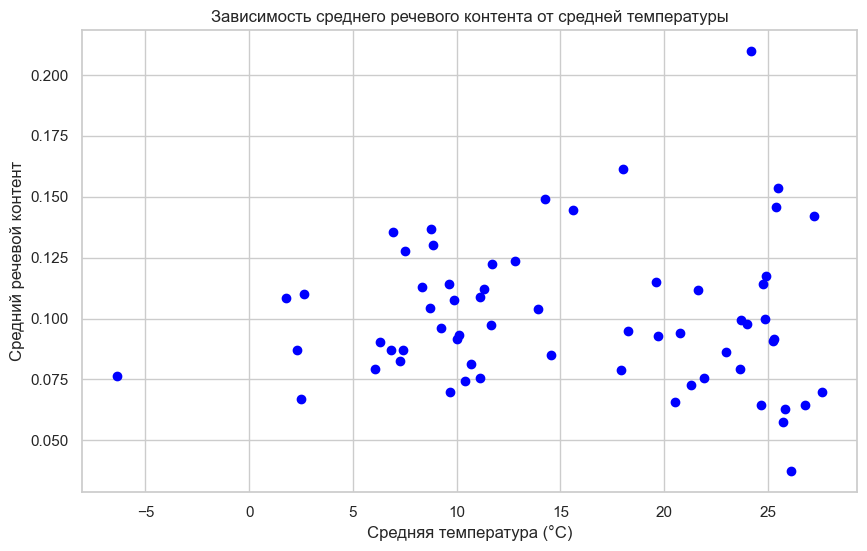

Корреляция между температурой и речевым контентом треков: -0.001672905913157046
                               OLS Regression Results                              
Dep. Variable:     Средний_речевой_контент   R-squared:                       0.000
Model:                                 OLS   Adj. R-squared:                 -0.016
Method:                      Least Squares   F-statistic:                 0.0001707
Date:                     Sun, 02 Jun 2024   Prob (F-statistic):              0.990
Time:                             23:50:37   Log-Likelihood:                 132.95
No. Observations:                       63   AIC:                            -261.9
Df Residuals:                           61   BIC:                            -257.6
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                          coef    std err          t      P>|t|      [0.025     

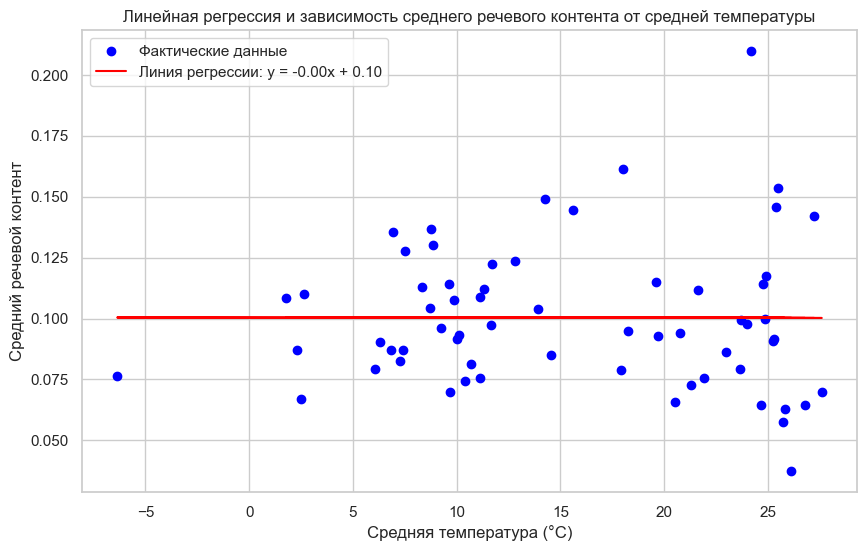

(-0.001672905913157046, -5.969522464844429e-06, 0.10040936826761682)

In [31]:
import statsmodels.api as sm

analysis_data = df.groupby('Страны').agg(
    Средняя_температура=pd.NamedAgg(column='Температура (ср. годовая)', aggfunc='mean'),
    Средний_речевой_контент=pd.NamedAgg(column='Речевой контент', aggfunc='mean')
).reset_index()
analysis_data = analysis_data.dropna()

plt.figure(figsize=(10, 6))
plt.scatter(analysis_data['Средняя_температура'], analysis_data['Средний_речевой_контент'], color='blue')
plt.title('Зависимость среднего речевого контента от средней температуры')
plt.xlabel('Средняя температура (°C)')
plt.ylabel('Средний речевой контент')
plt.grid(True)
plt.show()

correlation = analysis_data['Средняя_температура'].corr(analysis_data['Средний_речевой_контент'], method='pearson')
print(f"Корреляция между температурой и речевым контентом треков: {correlation}")

X = analysis_data[['Средняя_температура']]
y = analysis_data['Средний_речевой_контент']
X = sm.add_constant(X) 

model = sm.OLS(y, X).fit()
print(model.summary())

slope = model.params['Средняя_температура']
intercept = model.params['const']

plt.figure(figsize=(10, 6))
plt.scatter(analysis_data['Средняя_температура'], y, color='blue', label='Фактические данные')
plt.plot(analysis_data['Средняя_температура'], model.predict(X), color='red', label='Линия регрессии: y = {:.2f}x + {:.2f}'.format(slope, intercept))
plt.title('Линейная регрессия и зависимость среднего речевого контента от средней температуры')
plt.xlabel('Средняя температура (°C)')
plt.ylabel('Средний речевой контент')
plt.legend()
plt.grid(True)
plt.show()

correlation, slope, intercept


### Вывод по гипотезе 6:

Коэффициент корреляции отрицательный (-0.002) - существует незначительная обратная зависимость между средней температурой и средним речевым контентом. R^2 (R-квадрат): Очень близок к нулю (0.000) - всего лишь очень малая часть вариации в среднем речевом контенте треков объясняется средней температурой. p-значение: высокое (0.990), что указывает на то, что модель не является статистически значимой. Таким образом, гипотеза о влиянии средней температуры на средний речевой контент треков не подтверждается

Возможно, это связано со сравнительно небольшим количеством данных (стран), которыми мы располагаем: представлена лишь 1 страна с отрицательным значением среднегодовой температуры, хотя очевидно, что стран, с такой температурой, существует множество.